In [1]:
#%%appyter init
from appyter import magic
magic.init(lambda _=globals: _())

In [2]:
%%appyter hide_code
{% do SectionField(
    name='PRIMARY',
    title='Upload gene sets',
    subtitle='Upload your up and down gene sets',
    img='file-upload.png'
) %}

In [3]:
%%appyter markdown

{% set title = StringField(
    name='title',
    label='Notebook name',
    default='LDP3 Consensus Perturbagens',
    section="PRIMARY",
) %}

# {{ title.raw_value }}




# LDP3 Consensus Perturbagens

In [4]:
import re
import math
import time
import requests
import pandas as pd
import json
import scipy.stats as st
from IPython.display import display, IFrame, Markdown, HTML
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.manifold import TSNE
from maayanlab_bioinformatics.normalization import quantile_normalize, zscore_normalize
from maayanlab_bioinformatics.harmonization import ncbi_genes_lookup
from tqdm import tqdm
import plotly.express as px


In [5]:
METADATA_API = "https://ldp3.cloud/metadata-api"
DATA_API = "https://ldp3.cloud/data-api/api/v1"
CLUSTERGRAMMER_URL = 'https://amp.pharm.mssm.edu/clustergrammer/matrix_upload/'
S3_PREFIX = "https://appyters.maayanlab.cloud/storage/LDP3Consensus/"

In [6]:
ncbi_lookup = ncbi_genes_lookup('Mammalia/Homo_sapiens')

In [7]:
table = 1
figure = 1

In [8]:
# functions
def convert_genes(up_genes=[], down_genes=[]):
    try:
        payload = {
           "filter": {
               "where": {
                   "meta.symbol": {"inq": up_genes + down_genes}
               }
           }
        }
        timeout = 0.5
        for i in range(5):
            res = requests.post(METADATA_API + "/entities/find", json=payload)
            if res.ok:
                break
            else:
                time.sleep(timeout)
                if res.status_code >= 500:
                    timeout = timeout * 2
        else:
            raise Exception(res.text)
        results = res.json()
        up = set(up_genes)
        down = set(down_genes)
        if len(up_genes) == 0 or len(down_genes) == 0:
            converted = {
                "entities": [],
            }
        else:
            converted = {
                "up_entities": [],
                "down_entities": []
            }
        for i in results:
            symbol = i["meta"]["symbol"]
            if "entities" in converted:
                converted["entities"].append(i["id"])
            elif symbol in up:
                converted["up_entities"].append(i["id"])
            elif symbol in down:
                converted["down_entities"].append(i["id"])
        return converted
    except Exception as e:
        print(e)


def signature_search(genes, library):
    try:
        payload = {
            **genes,
            "database": library,
            "limit": 1000
        }
        timeout = 0.5
        for i in range(5):
            endpoint = "/enrich/rank" if "entities" in payload else "/enrich/ranktwosided"
            res = requests.post(DATA_API + endpoint, json=payload)
            if res.ok:
                break
            else:
                time.sleep(timeout)
                if res.status_code >= 500:
                    timeout = timeout * 2
        else:
            raise Exception(res.text)
        
        return res.json()["results"]
    except Exception as e:
        print(e)

def resolve_rank(s, gene_set_direction):
    try:
        sigs = {}
        for i in s:
            uid = i["uuid"]
            direction = "up" if i["zscore"] > 0 else "down"
            if direction == gene_set_direction:
                i["type"] = "mimicker"
                sigs[uid] = i
            else:
                i["type"] = "reverser"
                sigs[uid] = i
            
        payload = {
            "filter": {
                "where": {
                    "id": {"inq": list(sigs.keys())}
                },
                "fields": [
                    "id",
                    "meta.pert_name",
                    "meta.pert_type"
                ]
            }
        }
        timeout = 0.5
        for i in range(5):
            res = requests.post(METADATA_API + "/signatures/find", json=payload)
            if res.ok:
                break
            else:
                time.sleep(timeout)
                if res.status_code >= 500:
                    timeout = timeout * 2
        else:
            raise Exception(res.text)
        results = res.json()
        perturbagens = {
            "mimickers": {},
            "reversers": {}
        }
        for sig in results:
            uid = sig["id"]
            scores = sigs[uid]
            sig["scores"] = scores
            if "pert_name" in sig["meta"]:
                pert_name = sig["meta"]["pert_name"]
                if scores["type"] == "mimicker":
                    if pert_name not in perturbagens["mimickers"]:
                        perturbagens["mimickers"][pert_name] = 0
                    perturbagens["mimickers"][pert_name] += 1
                elif scores["type"] == "reverser":
                    if pert_name not in perturbagens["reversers"]:
                        perturbagens["reversers"][pert_name] = 0
                    perturbagens["reversers"][pert_name] += 1
        return perturbagens

    except Exception as e:
        print(e)


def resolve_ranktwosided(s):
    try:
        sigs = {}
        for i in s:
            uid = i["uuid"]
            i['z-down'] = -i['z-down']
            i['direction-down'] = -i['direction-down']
            if i['z-up'] > 0 and i['z-down'] > 0:
                i["type"] = "mimicker"
                sigs[uid] = i
            elif i['z-up'] < 0 and i['z-down'] < 0:
                i["type"] = "reverser"
                sigs[uid] = i
            
        payload = {
            "filter": {
                "where": {
                    "id": {"inq": list(sigs.keys())}
                },
                "fields": [
                    "id",
                    "meta.pert_name",
                    "meta.pert_type"
                ]
            }
        }
        timeout = 0.5
        for i in range(5):
            res = requests.post(METADATA_API + "/signatures/find", json=payload)
            if res.ok:
                break
            else:
                time.sleep(timeout)
                if res.status_code >= 500:
                    timeout = timeout * 2
        else:
            raise Exception(res.text)
        results = res.json()
        perturbagens = {
            "mimickers": {},
            "reversers": {}
        }
        for sig in results:
            uid = sig["id"]
            scores = sigs[uid]
            sig["scores"] = scores
            if "pert_name" in sig["meta"]:
                pert_name = sig["meta"]["pert_name"]
                if scores["type"] == "mimicker":
                    if pert_name not in perturbagens["mimickers"]:
                        perturbagens["mimickers"][pert_name] = 0
                    perturbagens["mimickers"][pert_name] += 1
                elif scores["type"] == "reverser":
                    if pert_name not in perturbagens["reversers"]:
                        perturbagens["reversers"][pert_name] = 0
                    perturbagens["reversers"][pert_name] += 1
        return perturbagens

    except Exception as e:
        print(e)

In [9]:
def clustergrammer(df, name, figure, label="Clustergrammer"):
    clustergram_df = df.rename(columns={i:"Signature: %s"%i for i in df.columns}, index={i:"Drug: %s"%i for i in df.index})
    clustergram_df.to_csv(name, sep="\t")
    response = ''
    timeout = 0.5
    for i in range(5):
        try:
            res = requests.post(CLUSTERGRAMMER_URL, files={'file': open(name, 'rb')})
            if not res.ok:
                response = res.text
                time.sleep(timeout)
                if res.status_code >= 500:
                    timeout = timeout * 2
            else:
                clustergrammer_url = res.text.replace("http:","https:")   
                break
        except Exception as e:
            response = e
            time.sleep(2)
    else:
        if type(response) == Exception:
            raise response
        else:
            raise Exception(response)
    print(clustergrammer_url)
    display(IFrame(clustergrammer_url, width="1000", height="1000"))
    display(Markdown("**Figure %d** %s [Go to url](%s)"%(figure, label, clustergrammer_url)))
    figure += 1
    return figure

cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1, dark=0)

def heatmap(df, filename, figure, label, width=15, height=15):
    fig = plt.figure(figsize=(width,height))
    cg = sns.clustermap(df, cmap=cmap, figsize=(width, height))
    cg.ax_row_dendrogram.set_visible(False)
    cg.ax_col_dendrogram.set_visible(False)
    display(cg)
    plt.show()
    cg.savefig(filename)
    display(Markdown("**Figure %d** %s"%(figure, label)))
    figure+=1
    return figure

In [10]:
%%appyter code_exec

{% set up_gene_sets = FileField(
    name='up_gene_sets',
    label='up gene sets',
    default='covid19_up.gmt',
    section="PRIMARY",
    examples={
        'covid19_up.gmt': 'https://appyters.maayanlab.cloud/storage/LDP3Consensus/covid19_down.gmt'
    }
) %}

{% set down_gene_sets = FileField(
    name='down_gene_sets',
    label='down gene sets',
    default='covid19_down.gmt',
    section="PRIMARY",
    examples={
        'covid19_down.gmt': 'https://appyters.maayanlab.cloud/storage/LDP3Consensus/covid19_down.gmt'
    }
) %}

{% set input_meta = FileField(
    name='input_meta',
    label='Metadata File',
    default='covid19_meta.tsv',
    section="PRIMARY",
    examples={
        'covid19_meta.tsv': 'https://appyters.maayanlab.cloud/storage/LDP3Consensus/covid19_meta.tsv',
    }
) %}
{% set color_by =  StringField(name='group_by', label='Group By', description="Group By Metadata", default='', section='PRIMARY')%}


up_gene_sets = {{ up_gene_sets }}
down_gene_sets = {{ down_gene_sets }}
input_meta = {{ input_meta }}
color_by = {{ color_by }}

```python
up_gene_sets = ''
down_gene_sets = 'covid19_down.gmt'
input_meta = 'covid19_meta.tsv'
color_by = ''
```

In [11]:
gene_set_direction = None
if up_gene_sets == '':
    gene_set_direction = "down"
    print("Up gene sets was not uploaded. Gene set direction is set to down.")
elif down_gene_sets == '':
    gene_set_direction = "up"
    print("Down gene sets was not uploaded. Gene set direction is set to up.")

Up gene sets was not uploaded. Gene set direction is set to down.


In [12]:
meta_df = pd.read_csv(input_meta, sep="\t", index_col=0)
display(meta_df.head())
display(Markdown("**Table %d** Input Metadata"%table))
table+=1
if color_by == "":
    color_by = meta_df.columns[0]

Cell Line/Tissue  \
untreated_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA...            Calu3   
mock_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA_GSE1...            Calu3   
mock_v_SARS-CoV-2_Human_Calu-3_s1_24h_polyA_GSE...            Calu3   
mock_v_SARS-CoV-2_Human_Calu-3_s2_4h_polyA_GSE1...            Calu3   
mock_v_SARS-CoV-2_Human_Calu-3_s2_12h_polyA_GSE...            Calu3   

                                                   SARS-CoV-2 Strain  \
untreated_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA...               NaN   
mock_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA_GSE1...               NaN   
mock_v_SARS-CoV-2_Human_Calu-3_s1_24h_polyA_GSE...               NaN   
mock_v_SARS-CoV-2_Human_Calu-3_s2_4h_polyA_GSE1...               NaN   
mock_v_SARS-CoV-2_Human_Calu-3_s2_12h_polyA_GSE...               NaN   

                                                   Time Point Medium  \
untreated_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA...         4h    NaN   
mock_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA_GSE1...         4h    NaN   
mock_v_SARS-CoV-2_Human_Calu-3_s1_24h_polyA_GSE...        24h    NaN   
mock_v_SARS-CoV-2_Human_Calu-3_s2_4h_polyA_GSE1...         4h    NaN   
mock_v_SARS-CoV-2_Human_Calu-3_s2_12h_polyA_GSE...        12h    NaN   

                                                   Virus Dose  
untreated_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA...        NaN  
mock_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA_GSE1...        NaN  
mock_v_SARS-CoV-2_Human_Calu-3_s1_24h_polyA_GSE...        NaN  
mock_v_SARS-CoV-2_Human_Calu-3_s2_4h_polyA_GSE1...        NaN  
mock_v_SARS-CoV-2_Human_Calu-3_s2_12h_polyA_GSE...        NaN

**Table 1** Input Metadata

In [13]:
%%appyter code_exec
alpha = {{FloatField(name='alpha', label='p-value cutoff', default=0.05, section='PRIMARY')}}
perc = {{FloatField(name='perc',
                         label='percentage',
                         description='Minimum percentage cutoff for perturbagen instances in signatures',
                         default=0.1, section='PRIMARY')}}
top_perts = {{IntField(name='top_perts', label='top perturbation', default=50, section='PRIMARY')}}
perplexity = {{IntField(name='perplexity', label='Perplexity', description="t-SNE perplexity", default=15, section='PRIMARY')}}
n_neighbors = {{IntField(name='n_neighbors', label='n_neighbors', description="UMAP's n_neighbors", default=15, section='PRIMARY')}}
random_state = {{IntField(name='random_state', label='Random State', description="Random State", default=21, section='PRIMARY')}}

width = {{FloatField(name='width', label='image width', default=10, section='PRIMARY')}}
height = {{FloatField(name='height', label='image height', default=10, section='PRIMARY')}}


```python
alpha = 0.05
perc = 0.1
top_perts = 50
perplexity = 10
n_neighbors = 10
random_state = 21
width = 10.0
height = 10.0
```

In [14]:
signatures = {}
if not up_gene_sets == '':
    with open(up_gene_sets) as upfile:
        for line in upfile:
            unpacked = line.strip().split("\t\t")
            if not len(unpacked) == 2:
                raise ValueError("GMT is not formatted properly, please consult the README of the appyter for proper formatting")
            sigid, geneset_str = unpacked
            genes = []
            for i in geneset_str.split("\t"):
                gene = i.split(",")[0]
                gene_name = ncbi_lookup(gene.upper())
                if gene_name:
                    genes.append(gene_name)
            signatures[sigid] = {
                "up_genes": genes,
                "down_genes": []
            }
if not down_gene_sets == '':
    with open(down_gene_sets) as downfile:
        for line in downfile:
            unpacked = line.strip().split("\t\t")
            if not len(unpacked) == 2:
                raise ValueError("GMT is not formatted properly, please consult the README of the appyter for proper formatting")
            sigid, geneset_str = unpacked
            if sigid not in signatures and gene_set_direction == None:
                raise ValueError("%s did not match any of the up signatures, make sure that the signature names are the same for both up and down genes"%sigid)
            else:
                genes = []
                for i in geneset_str.split("\t"):
                    gene = i.split(",")[0]
                    gene_name = ncbi_lookup(gene)
                    if gene_name:
                        genes.append(gene_name)
                if sigid in signatures:
                    signatures[sigid]["down_genes"] = genes
                else:
                    signatures[sigid] = {
                        "up_genes": [],
                        "down_genes": genes
                    }

In [15]:
%%appyter code_exec

datasets = {{ MultiChoiceField(name='datasets',
                                description='Select the LINCS Dataset that you want to use for Signature Search',
                                label='LINCS Datasets',
                                default=[
                                    "LINCS L1000 CRISPR Perturbations (2021)",
                                    "LINCS L1000 Chemical Perturbations (2021)",
                                ],
                                section = 'PRIMARY',
                                choices=[
                                    "LINCS L1000 Antibody Perturbations (2021)",
                                    "LINCS L1000 Ligand Perturbations (2021)",
                                    "LINCS L1000 Overexpression Perturbations (2021)",
                                    "LINCS L1000 CRISPR Perturbations (2021)",
                                    "LINCS L1000 shRNA Perturbations (2021)",
                                    "LINCS L1000 Chemical Perturbations (2021)",
                                    "LINCS L1000 siRNA Perturbations (2021)",
                                ]
                              )                           
}}


```python

datasets = ['LINCS L1000 CRISPR Perturbations (2021)', 'LINCS L1000 Chemical Perturbations (2021)']
```

In [16]:
dataset_map = {
  "LINCS L1000 Antibody Perturbations (2021)": "l1000_aby",
  "LINCS L1000 Ligand Perturbations (2021)": "l1000_lig",
  "LINCS L1000 Overexpression Perturbations (2021)": "l1000_oe",
  "LINCS L1000 CRISPR Perturbations (2021)": "l1000_xpr",
  "LINCS L1000 shRNA Perturbations (2021)": "l1000_shRNA",
  "LINCS L1000 Chemical Perturbations (2021)": "l1000_cp",
  "LINCS L1000 siRNA Perturbations (2021)": "l1000_siRNA"
}

gene_page = {
  "LINCS L1000 Ligand Perturbations (2021)",
  "LINCS L1000 Overexpression Perturbations (2021)",
  "LINCS L1000 CRISPR Perturbations (2021)",
  "LINCS L1000 shRNA Perturbations (2021)",
  "LINCS L1000 siRNA Perturbations (2021)"
}

In [17]:
# enriched = {lib:{"mimickers": {}, "reversers": {}} for lib in datasets}
enriched = {"mimickers": {lib: {} for lib in datasets}, "reversers": {lib: {} for lib in datasets}}

for k,sig in tqdm(signatures.items()):    
    try:
        time.sleep(0.1)
        genes = convert_genes(sig["up_genes"],sig["down_genes"])
        if ("entities" in genes and len(genes["entities"]) > 5) or (len(genes["up_entities"]) > 5 and len(genes["down_entities"]) > 5):
            for lib in datasets:
                library = dataset_map[lib]
                s = signature_search(genes, library)
                if gene_set_direction == None:
                    perturbagens = resolve_ranktwosided(s)
                else:
                    perturbagens = resolve_rank(s, gene_set_direction)
                enriched["mimickers"][lib][k] = perturbagens["mimickers"]
                enriched["reversers"][lib][k] = perturbagens["reversers"]
                time.sleep(0.1)
    except Exception as e:
        print(e)

100%|██████████| 123/123 [08:56<00:00,  4.36s/it]


In [18]:
def make_clickable(link):
    # target _blank to open new window
    # extract clickable text to display for your link
    text = link.split('=')[1]
    return f'<a target="_blank" href="{link}">{text}</a>'

def metadata_plot(df, x,y):
    colors = meta_df.columns
    plot_rows = int(len(colors)/2) if len(colors) % 2 == 0 else int(len(colors)/2 + 1)
    fig, axes = plt.subplots(plot_rows, 2, sharex=True, sharey=True, figsize=(20,8*plot_rows))
    ax_1 = 0
    ax_2 = 0
    for color in colors:
        if ax_2 == 2:
            ax_2 = 0
            ax_1+=1
        sns.scatterplot(
            data=df,
            x=x, y=y,
            hue=color,
            ax=axes[ax_1, ax_2] if plot_rows > 1 else axes[ax_2]
        )
        if plot_rows > 1:
            axes[ax_1, ax_2].set_title(color)
        else:
            axes[ax_2].set_title(color)
        ax_2+=1
    if plot_rows * 2 > len(colors):
        if plot_rows > 1:
            fig.delaxes(axes[ax_1, ax_2])
        else:
            fig.delaxes(axes[ax_2])
    plt.show()

def get_tsne(df, label, figure):
#     perplexity = min(10, len(df.columns)-1)
    X_embedded = TSNE(n_components=2,
                      perplexity=perplexity,
                      random_state=random_state,
                     ).fit_transform(df.T)
    tsne_df = pd.DataFrame(X_embedded, columns=["t-SNE 1", "t-SNE 2"])
    tsne_df['label'] = df.columns
    if (not input_meta == ""):
        tsne_df = tsne_df.merge(right=meta_df, left_on="label", right_index=True)
    if color_by:
        display(
            px.scatter(
                tsne_df.loc[~tsne_df[color_by].isna()],
                x="t-SNE 1",
                y="t-SNE 2",
                color=color_by,
                hover_data=tsne_df.columns,
              )
        )
        display(Markdown("**Figure %d** t-SNE plot of %s colored by %s"%(figure, label, color_by)))
    else:
        px.scatter(
            tsne_df,
            x="t-SNE 1",
            y="t-SNE 2",
            hover_data=tsne_df.columns,
          )
        display(Markdown("**Figure %d** t-SNE plot of %s"%(figure, label)))
    if not input_meta == "" and len(meta_df.columns) > 1:
        metadata_plot(tsne_df, 't-SNE 1', 't-SNE 2')
        figure+=1
        display(Markdown("**Figure %d** t-SNE plot of %s colored by metadata"%(figure, label)))
    return figure + 1

def get_umap(df, label, figure):
#     n_neighbors = min(15, len(df.columns)-1)
    
    consensus_umap = UMAP(
      random_state=random_state,
      n_neighbors=n_neighbors,
      n_components=2,
      metric='cosine',
      min_dist=0.3,
    )
    consensus_umap.fit(df.T.values)
    umap_df = pd.DataFrame(consensus_umap.transform(df.T.values),
                           columns=["UMAP 1", "UMAP 2"])
    umap_df['label'] = df.columns
    if (not input_meta == ""):
        umap_df = umap_df.merge(right=meta_df, left_on="label", right_index=True)
#     display(app.run_server(mode='inline'))
    if color_by:
        display(
            px.scatter(
                umap_df.loc[~umap_df[color_by].isna()],
                x="UMAP 1",
                y="UMAP 2",
                color=color_by,
                hover_data=umap_df.columns,
              )
        )
        display(Markdown("**Figure %d** UMAP plot of %s colored by %s"%(figure, label, color_by)))
    else:
        display(
            px.scatter(
                umap_df,
                x="UMAP 1",
                y="UMAP 2",
                color=color_by,
                hover_data=umap_df.columns,
              )
        )
        display(Markdown("**Figure %d** UMAP plot of %s"%(figure, label)))
    if not input_meta == "" and len(meta_df.columns) > 1:
        metadata_plot(umap_df, 'UMAP 1', 'UMAP 2')
        figure+=1
        display(Markdown("**Figure %d** UMAP plot of %s colored by metadata"%(figure, label)))
    return figure + 1


## Mimickers

### LINCS L1000 CRISPR Perturbations (2021)

**Table 3** Top 25 mimicker perturbagens using LINCS L1000 CRISPR Perturbations (2021) dataset ([download](./pert_stat_LINCS_L1000_CRISPR_Perturbations_(2021)_mimickers.tsv))

untreated_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA_GSE148729  \
CXCL5                                                  0           
CD24                                                   0           
SFXN1                                                  0           
EEF2                                                   2           
FABP2                                                  1           

       mock_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA_GSE148729  \
CXCL5                                                  1      
CD24                                                   0      
SFXN1                                                  0      
EEF2                                                   0      
FABP2                                                  0      

       mock_v_SARS-CoV-2_Human_Calu-3_s1_24h_polyA_GSE148729  \
CXCL5                                                  0       
CD24                                                   0       
SFXN1                                                  0       
EEF2                                                   2       
FABP2                                                  0       

       mock_v_SARS-CoV-2_Human_Calu-3_s2_4h_polyA_GSE148729  \
CXCL5                                                  1      
CD24                                                   1      
SFXN1                                                  0      
EEF2                                                   1      
FABP2                                                  0      

       mock_v_SARS-CoV-2_Human_Calu-3_s2_12h_polyA_GSE148729  \
CXCL5                                                  0       
CD24                                                   0       
SFXN1                                                  0       
EEF2                                                   1       
FABP2                                                  0       

       untreated_v_SARS-CoV-2_Human_H1299_4h_polyA_GSE148729  \
CXCL5                                                  0       
CD24                                                   0       
SFXN1                                                  0       
EEF2                                                   0       
FABP2                                                  0       

       mock_v_SARS-CoV-2_Human_H1299_4h_polyA_GSE148729  \
CXCL5                                                 0   
CD24                                                  0   
SFXN1                                                 0   
EEF2                                                  0   
FABP2                                                 0   

       mock_v_SARS-CoV-2_Human_H1299_36h_polyA_GSE148729  \
CXCL5                                                  0   
CD24                                                   0   
SFXN1                                                  0   
EEF2                                                   0   
FABP2                                                  0   

       untreated_v_SARS-CoV-2_Human_Caco2_4h_polyA_GSE148729  \
CXCL5                                                  1       
CD24                                                   1       
SFXN1                                                  0       
EEF2                                                   0       
FABP2                                                  0       

       mock_v_SARS-CoV-2_Human_Caco2_4h_polyA_GSE148729  ...  \
CXCL5                                                 0  ...   
CD24                                                  2  ...   
SFXN1                                                 0  ...   
EEF2                                                  0  ...   
FABP2                                                 0  ...   

       Control-vs-SARS-CoV-2_Day14_Ferret_NasalTurbinates_GSE160824  \
CXCL5                                                  0              
CD24                                                   0 

**Table 4** Consensus mimicker perturbation matrix for LINCS L1000 CRISPR Perturbations (2021) ([download](./consensus_matrix_l1000_xpr_mimickers.tsv))

**Figure 1** t-SNE plot of LINCS L1000 CRISPR Perturbations (2021) mimickers colored by Cell Line/Tissue

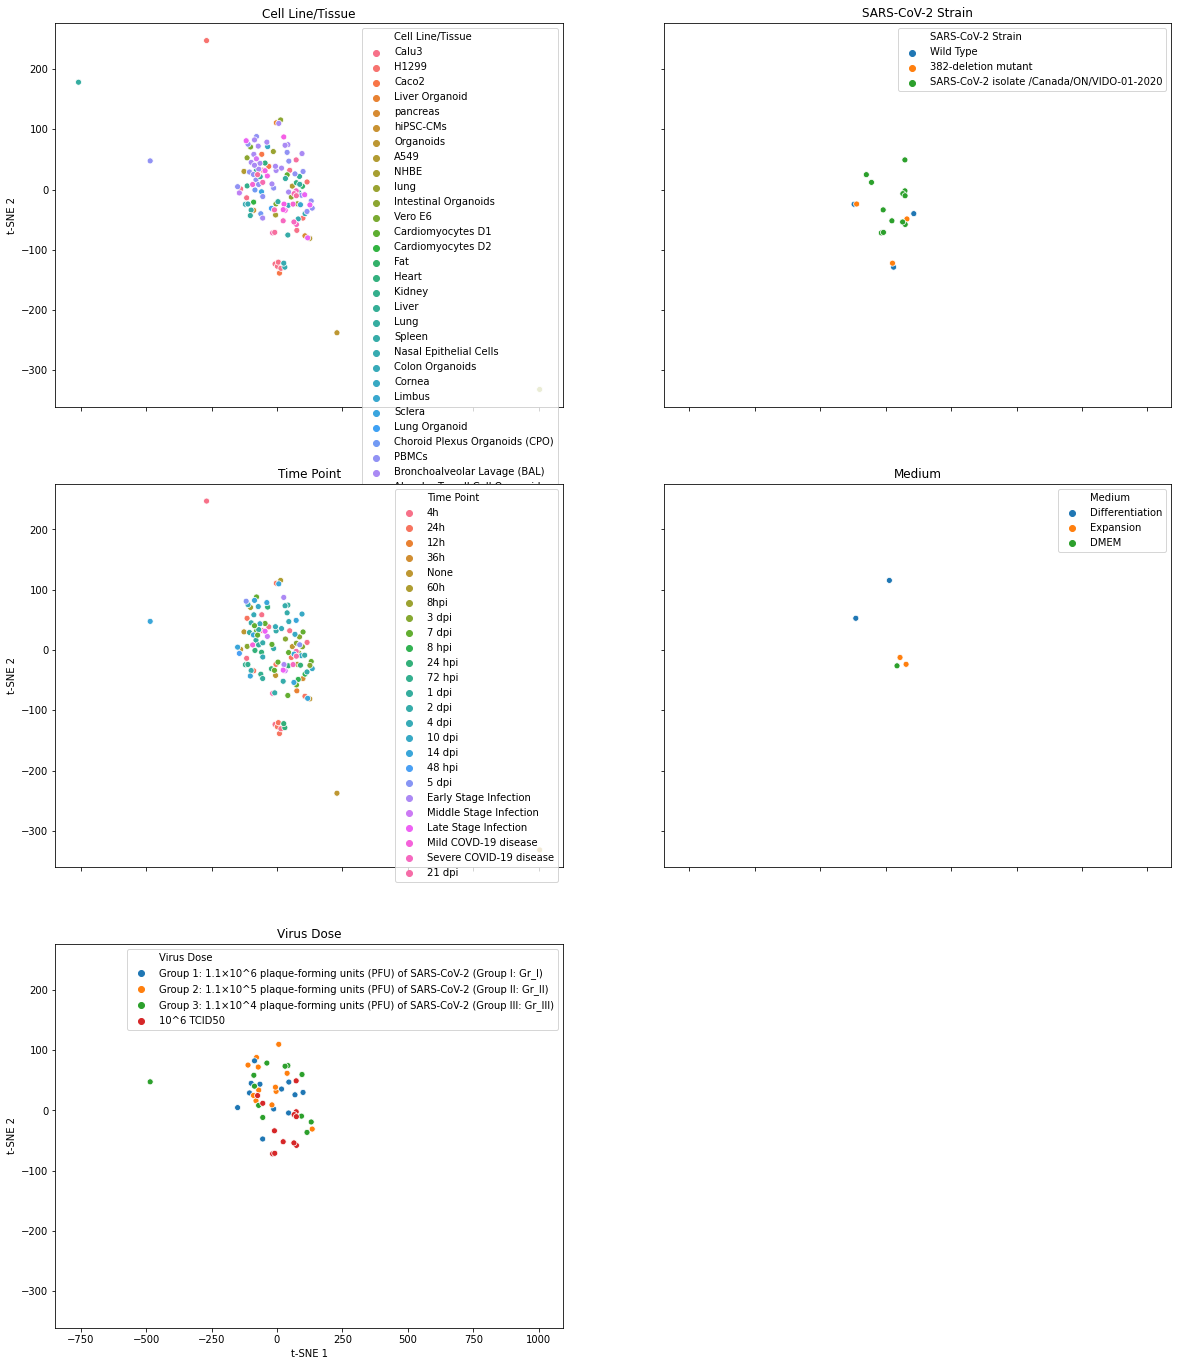

**Figure 2** t-SNE plot of LINCS L1000 CRISPR Perturbations (2021) mimickers colored by metadata

**Figure 3** UMAP plot of LINCS L1000 CRISPR Perturbations (2021) mimickers colored by Cell Line/Tissue

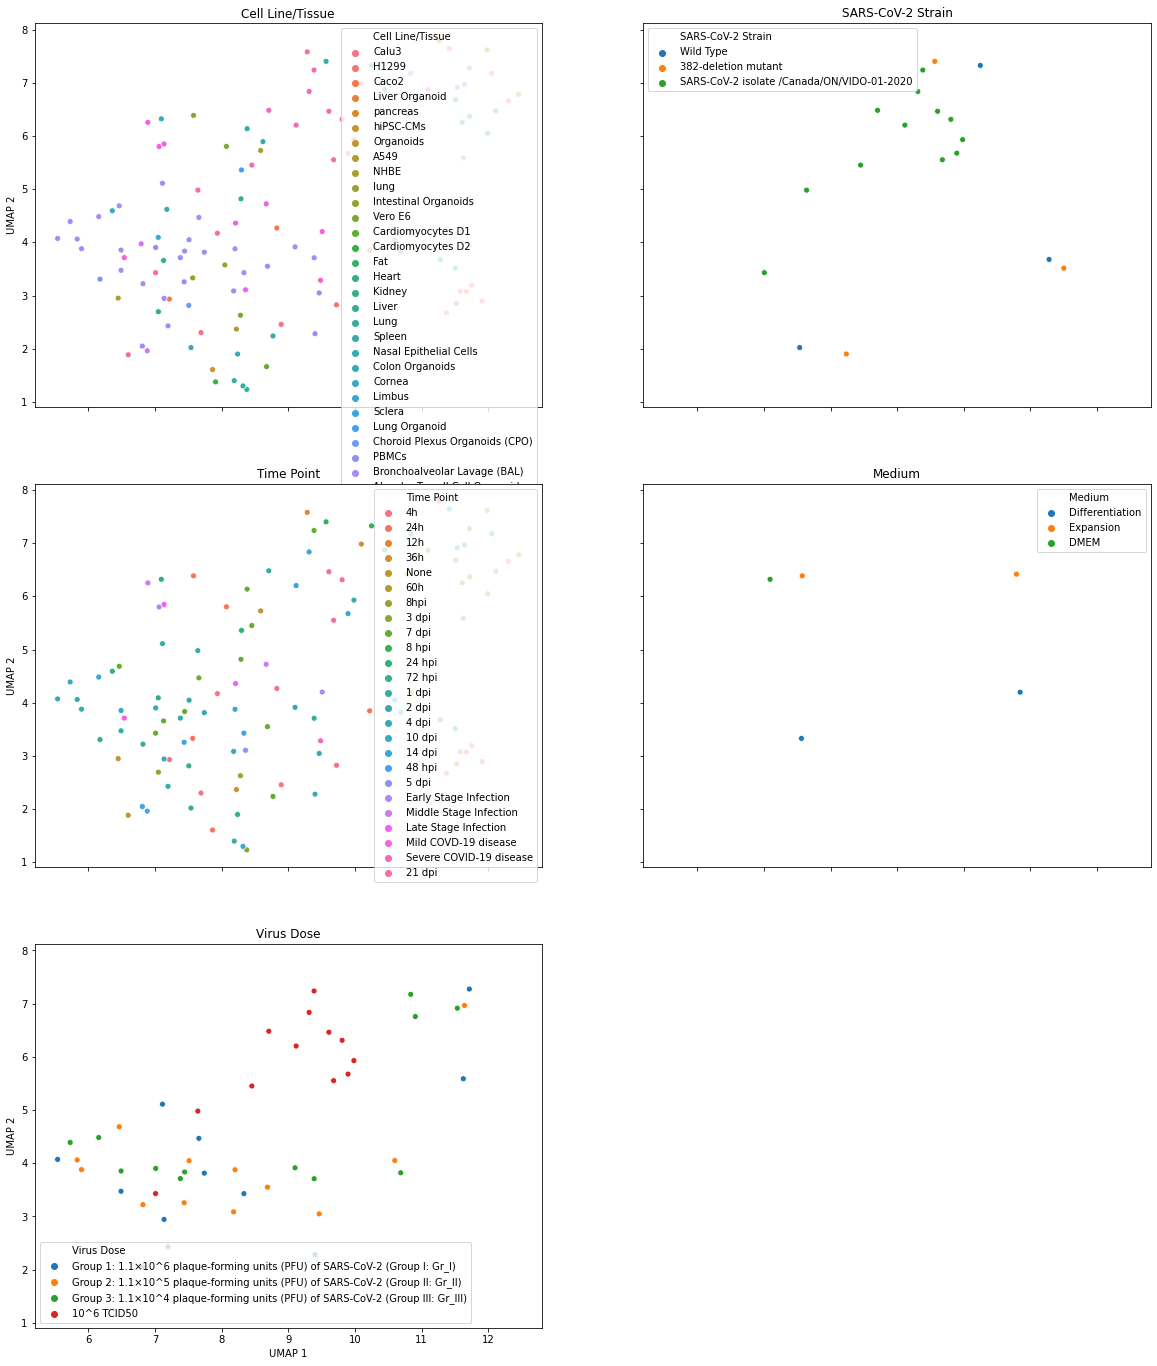

**Figure 4** UMAP plot of LINCS L1000 CRISPR Perturbations (2021) mimickers colored by metadata

https://maayanlab.cloud/clustergrammer/viz/61087d6597f268000e93c7cd/clustergrammer_l1000_xpr_mimickers.tsv


**Figure 5** Clustergrammer of consensus mimicker perturbation of LINCS L1000 CRISPR Perturbations (2021) (quantile normalized scores) [Go to url](https://maayanlab.cloud/clustergrammer/viz/61087d6597f268000e93c7cd/clustergrammer_l1000_xpr_mimickers.tsv)

<Figure size 1080x1080 with 0 Axes>

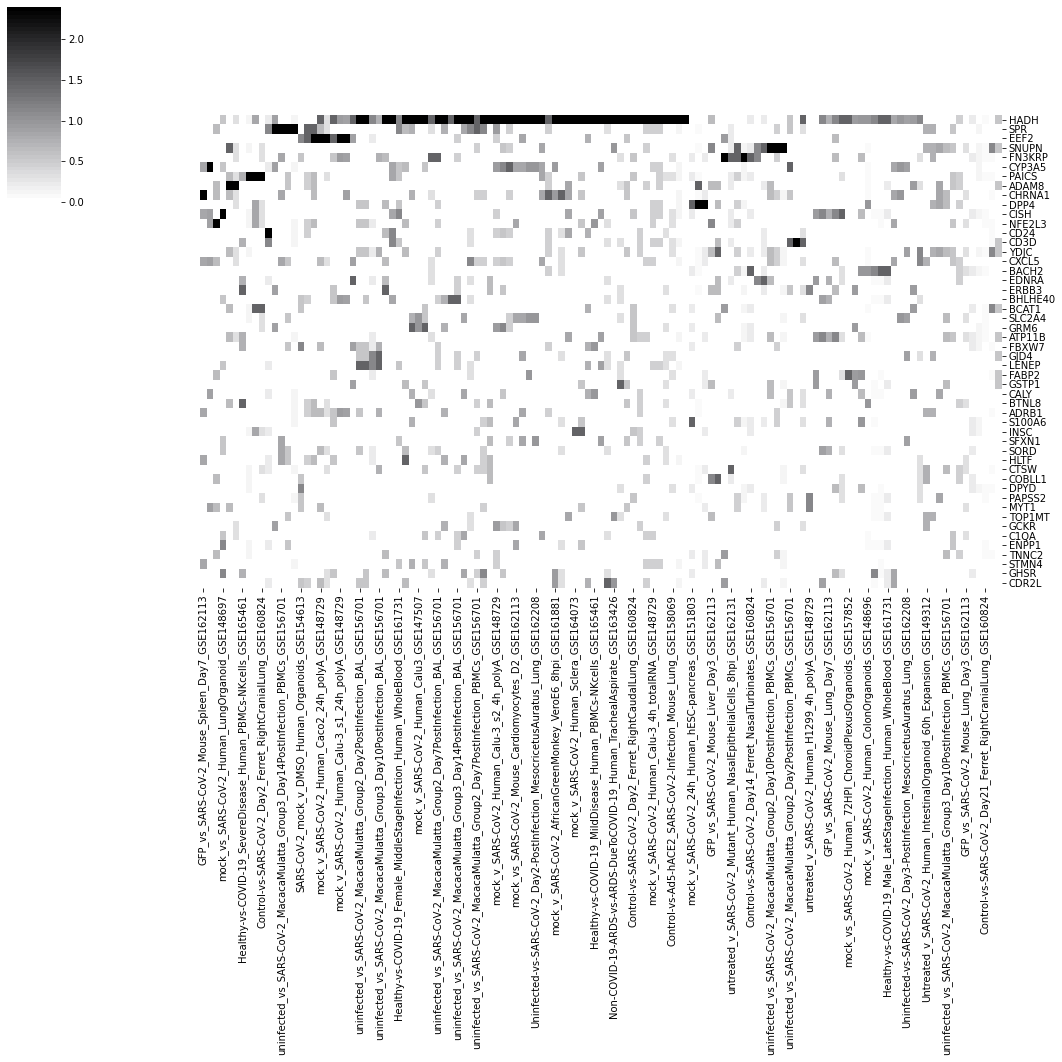

**Figure 6** Heatmap of consensus mimicker perturbation of LINCS L1000 CRISPR Perturbations (2021) (quantile normalized scores)

### LINCS L1000 Chemical Perturbations (2021)

count    z-score       p-value
BRD-K65183353       18  12.914035  0.000000e+00
BRD-K38290133       17  12.195959  0.000000e+00
BRD-K14268329       16  11.477884  0.000000e+00
BRD-K54023716       14  10.041733  0.000000e+00
BRD-K11901207       19   9.631969  0.000000e+00
BRD-K60065591       13   9.323658  0.000000e+00
digoxin            115   8.912320  0.000000e+00
roscovitine         79   8.500422  0.000000e+00
PJ-34               67   8.330988  0.000000e+00
AG-14361            83   7.844143  2.220446e-15
importazole         99   7.699214  6.883383e-15
BRD-K55662526       15   7.600815  1.476597e-14
pyrazolanthrone     21   7.518593  2.764455e-14
BRD-K89216747       14   7.093026  6.560308e-13
BRD-K68368772       14   7.093026  6.560308e-13
BRD-K09468701       17   7.029168  1.038836e-12
BS-181              31   7.007577  1.212364e-12
rucaparib          117   6.796701  5.352052e-12
BRD-K15318383       21   6.720201  9.073742e-12
BRD-K78830924       16   6.614534  1.863620e-11
THZ-2-98-01         24   6.486307  4.398282e-11
imiloxan            25   6.317761  1.326896e-10
lamotrigine         53   6.296083  1.526309e-10
gatifloxacin        38   6.217863  2.519859e-10
diclofenac          15   6.199900  2.824959e-10

**Table 6** Top 25 mimicker perturbagens using LINCS L1000 Chemical Perturbations (2021) dataset ([download](./pert_stat_l1000_cp_mimickers.tsv))

untreated_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA_GSE148729  \
BRD-K65183353                                                  1           
BRD-K38290133                                                  1           
BRD-K14268329                                                  1           
BRD-K54023716                                                  0           
BRD-K11901207                                                  0           

               mock_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA_GSE148729  \
BRD-K65183353                                                  1      
BRD-K38290133                                                  1      
BRD-K14268329                                                  1      
BRD-K54023716                                                  0      
BRD-K11901207                                                  1      

               mock_v_SARS-CoV-2_Human_Calu-3_s1_24h_polyA_GSE148729  \
BRD-K65183353                                                  0       
BRD-K38290133                                                  0       
BRD-K14268329                                                  0       
BRD-K54023716                                                  0       
BRD-K11901207                                                  0       

               mock_v_SARS-CoV-2_Human_Calu-3_s2_4h_polyA_GSE148729  \
BRD-K65183353                                                  0      
BRD-K38290133                                                  0      
BRD-K14268329                                                  0      
BRD-K54023716                                                  0      
BRD-K11901207                                                  0      

               mock_v_SARS-CoV-2_Human_Calu-3_s2_12h_polyA_GSE148729  \
BRD-K65183353                                                  0       
BRD-K38290133                                                  0       
BRD-K14268329                                                  0       
BRD-K54023716                                                  0       
BRD-K11901207                                                  0       

               untreated_v_SARS-CoV-2_Human_H1299_4h_polyA_GSE148729  \
BRD-K65183353                                                  0       
BRD-K38290133                                                  0       
BRD-K14268329                                                  0       
BRD-K54023716                                                  0       
BRD-K11901207                                                  0       

               mock_v_SARS-CoV-2_Human_H1299_4h_polyA_GSE148729  \
BRD-K65183353                                                 0   
BRD-K38290133                                                 0   
BRD-K14268329                                                 0   
BRD-K54023716                                                 0   
BRD-K11901207                                                 1   

               mock_v_SARS-CoV-2_Human_H1299_36h_polyA_GSE148729  \
BRD-K65183353                                                  0   
BRD-K38290133                                                  0   
BRD-K14268329                                                  0   
BRD-K54023716                                                  0   
BRD-K11901207                                                  0   

               untreated_v_SARS-CoV-2_Human_Caco2_4h_polyA_GSE148729  \
BRD-K65183353                                                  0       
BRD-K38290133                                                  0       
BRD-K14268329                                                  0       
BRD-K54023716                                                  0       
BRD-K11901207                                                  0       

               mock_v_SARS-CoV-2_Human_Caco2_4h_polyA_GSE148729  ...  \
BRD-K65183353                                                 0  ...   
BRD-K38290133   

**Table 7** Consensus mimicker perturbation matrix for LINCS L1000 Chemical Perturbations (2021) ([download](./consensus_matrix_l1000_cp_mimickers.tsv))

**Figure 7** t-SNE plot of LINCS L1000 Chemical Perturbations (2021) mimickers colored by Cell Line/Tissue

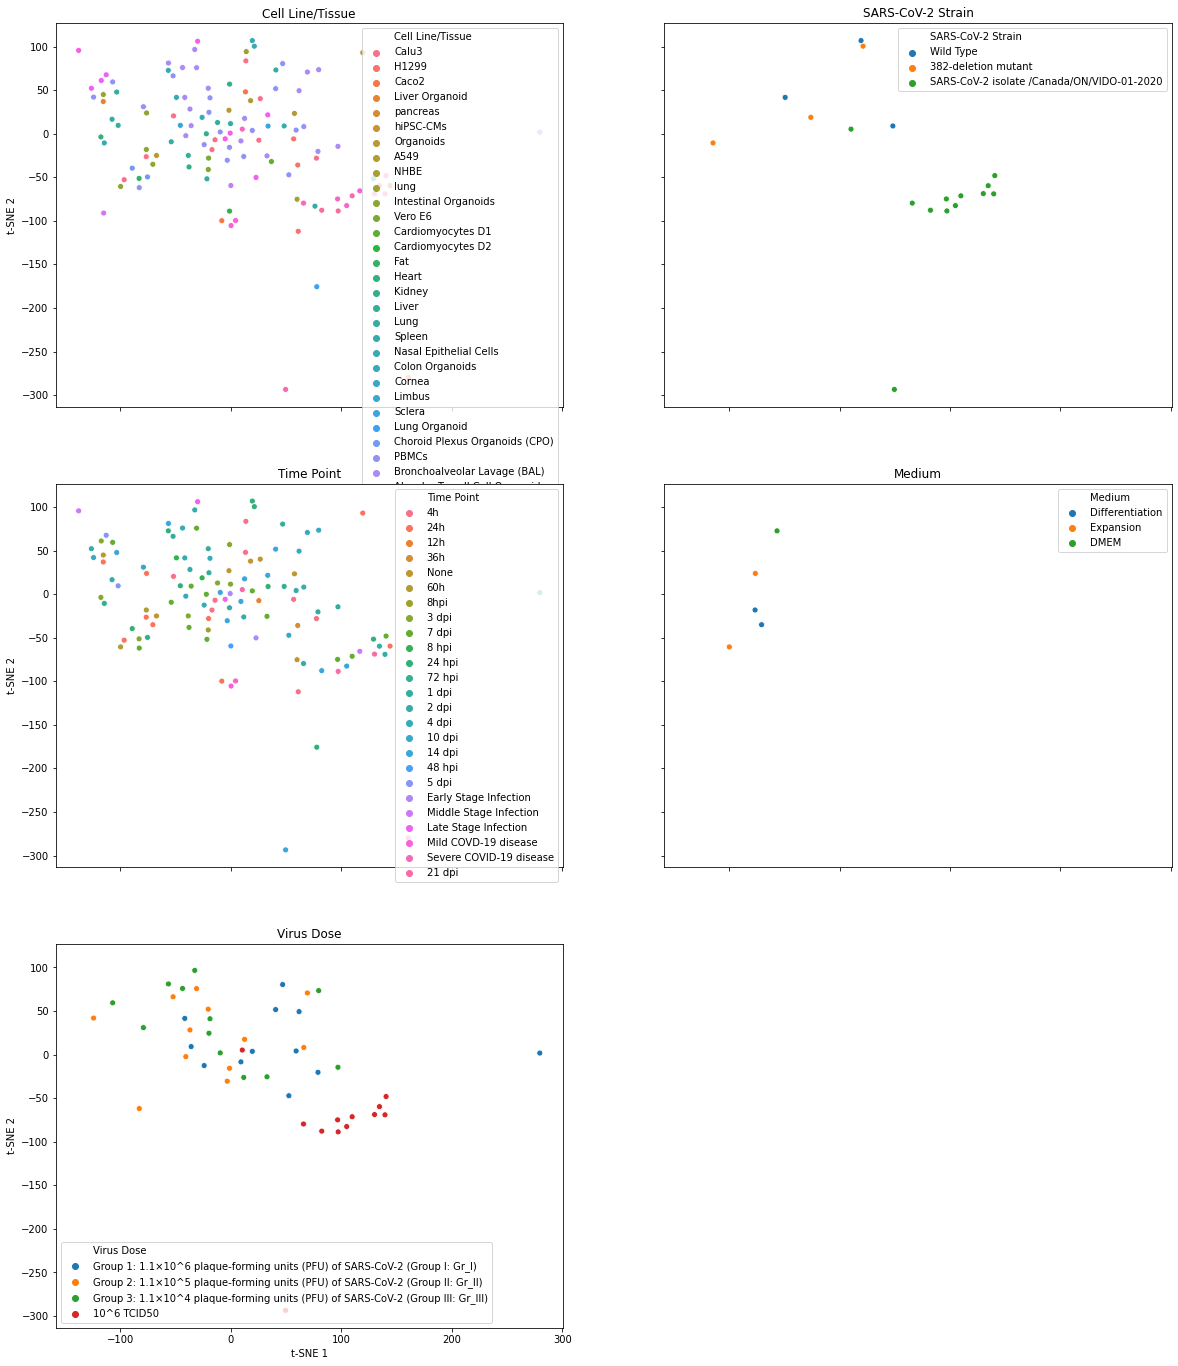

**Figure 8** t-SNE plot of LINCS L1000 Chemical Perturbations (2021) mimickers colored by metadata

**Figure 9** UMAP plot of LINCS L1000 Chemical Perturbations (2021) mimickers colored by Cell Line/Tissue

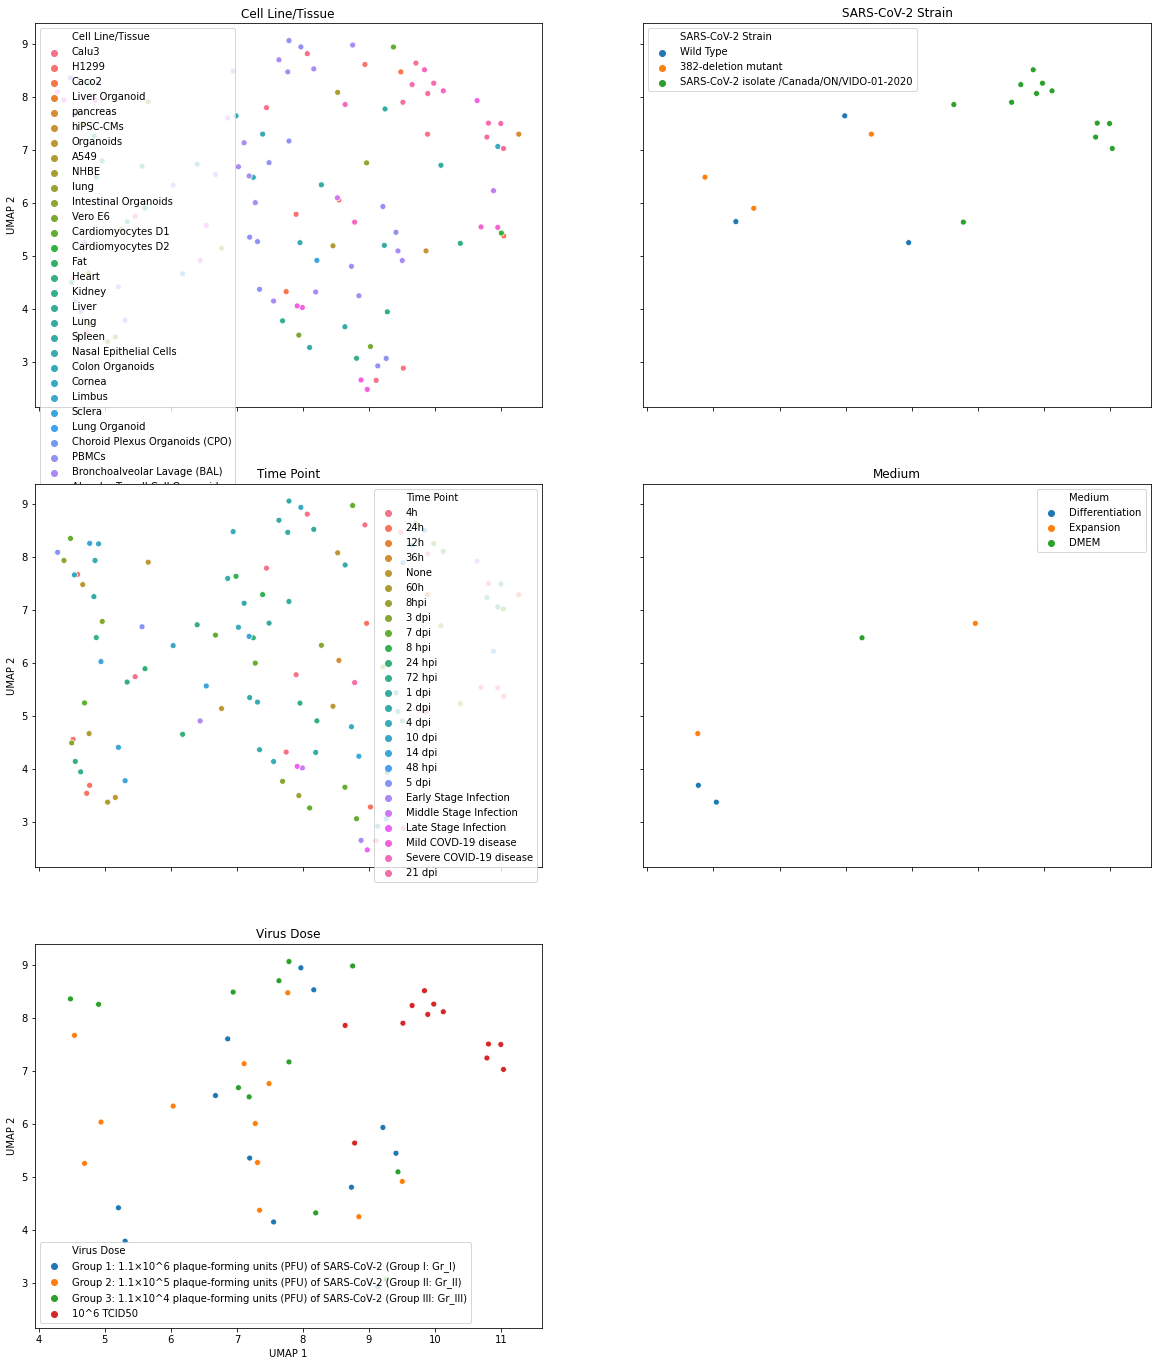

**Figure 10** UMAP plot of LINCS L1000 Chemical Perturbations (2021) mimickers colored by metadata

https://maayanlab.cloud/clustergrammer/viz/61087d7397f268000e93c7d2/clustergrammer_l1000_cp_mimickers.tsv


**Figure 11** Clustergrammer of consensus mimicker perturbation of LINCS L1000 Chemical Perturbations (2021) (quantile normalized scores) [Go to url](https://maayanlab.cloud/clustergrammer/viz/61087d7397f268000e93c7d2/clustergrammer_l1000_cp_mimickers.tsv)

<Figure size 1080x1080 with 0 Axes>

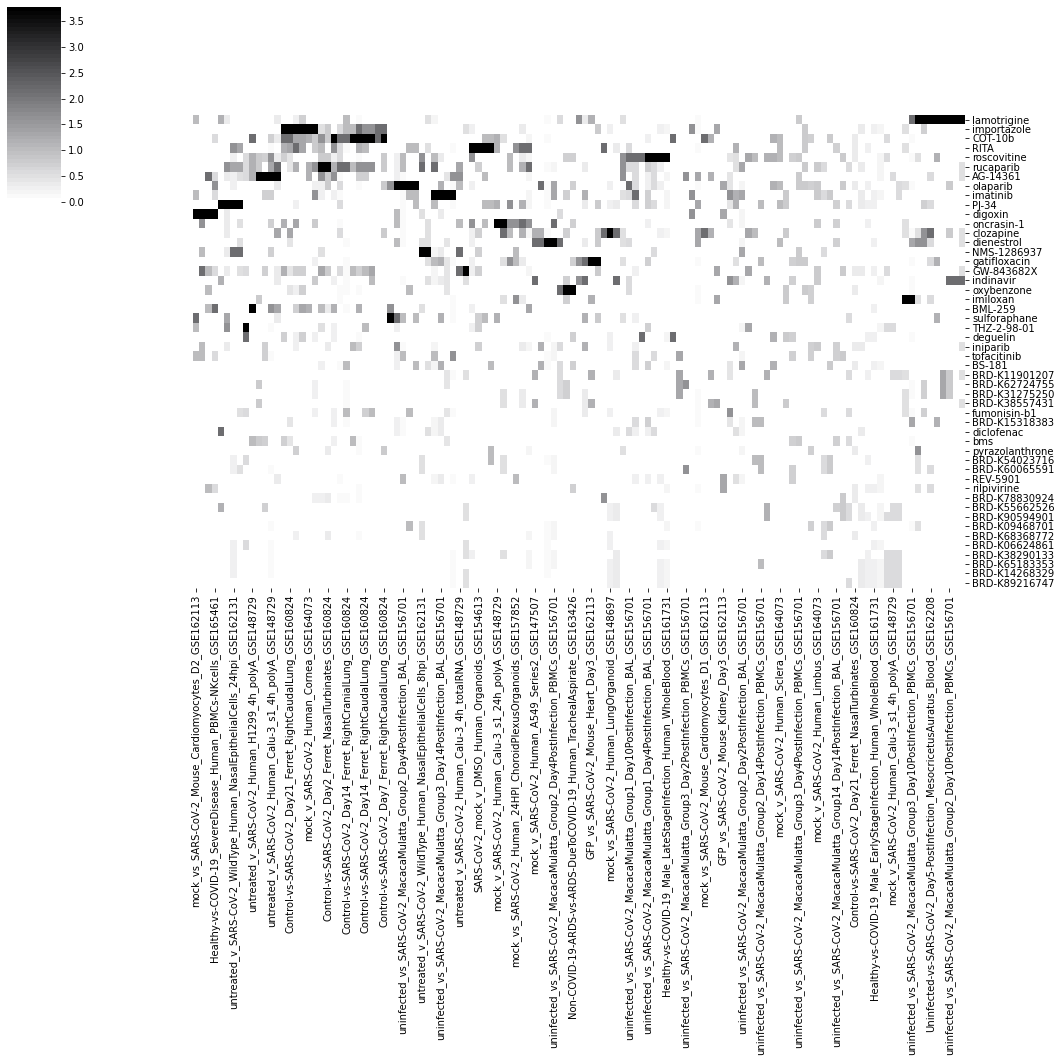

**Figure 12** Heatmap of consensus mimicker perturbation of LINCS L1000 Chemical Perturbations (2021) (quantile normalized scores)

In [19]:
direction = "mimickers"
for lib in datasets:
    library = dataset_map[lib]
    display(Markdown("### %s"%lib))
    index = set()
    pert_dict = enriched[direction][lib]
    for v in pert_dict.values():
        index = index.union(v.keys())
    df = pd.DataFrame(0, index=index, columns=pert_dict.keys())
    for k,v in pert_dict.items():
        for pert, cnt in v.items():
            df.at[pert, k] += cnt
    df = df.loc[df.sum(1).sort_values(ascending=False).index]
    filename = "pert_matrix_%s_%s.tsv"%(library.replace(" ","_"), direction)
    df.to_csv(filename, sep="\t")
#     display(df.head())
#     display(Markdown("**Table %d** Mimicker perturbagens using %s dataset ([download](./%s))"%
#                      (table, lib, filename)))
    table += 1
    # stat_df = pd.DataFrame(0, index=df.index, columns=["count", "z-score", "p-value"])
    empirical_stat = pd.read_csv(S3_PREFIX + "%s_%s.tsv" % (library, direction), sep="\t", index_col=0)
    df = df[(df>0).sum(1) > len(df.columns) * perc]
    index = set(df.index).intersection(empirical_stat.index)
    filtered_df = df.loc[index]    
    if lib in gene_page:
        stat_df = pd.DataFrame(0, index=index, columns=["count", "z-score", "p-value", "Enrichr gene page"])
        stat_df['count'] = filtered_df.sum(1)
        # Compute zstat and p value
        stat_df["z-score"] = (filtered_df.mean(1) - empirical_stat["mean"]) / empirical_stat["std"]
        stat_df["p-value"] = stat_df['z-score'].apply(lambda x: 1-st.norm.cdf(x))

        #Filter by p-value
        stat_df = stat_df[stat_df["p-value"]<alpha].sort_values(by=["z-score"], ascending=False)

        stat_df['Enrichr gene page'] = ["https://maayanlab.cloud/Enrichr/#find!gene=%s"%i for i in stat_df.index]
        filename = "pert_stat_%s_%s.tsv"%(lib.replace(" ","_"), direction)
        stat_df.to_csv(filename, sep="\t")
        stat_df['Enrichr gene page'] = stat_df['Enrichr gene page'].apply(make_clickable)
        stat_html = stat_df.head(25).to_html(escape=False)
        display(HTML(stat_html))
    else:
        stat_df = pd.DataFrame(0, index=index, columns=["count", "z-score", "p-value"])
        stat_df['count'] = filtered_df.sum(1)
        # Compute zstat and p value
        stat_df["z-score"] = (filtered_df.mean(1) - empirical_stat["mean"]) / empirical_stat["std"]
        stat_df["p-value"] = stat_df['z-score'].apply(lambda x: 1-st.norm.cdf(x))

        #Filter by p-value
        stat_df = stat_df[stat_df["p-value"]<alpha].sort_values(by=["z-score"], ascending=False)

        filename = "pert_stat_%s_%s.tsv"%(library.replace(" ","_"), direction)
        stat_df.to_csv(filename, sep="\t")
        display(stat_df.head(25))
    display(Markdown("**Table %d** Top 25 mimicker perturbagens using %s dataset ([download](./%s))"%
                     (table, lib, filename)))

    table+=1

    consensus = df.loc[stat_df.index[0:top_perts]]
    consensus_norm = quantile_normalize(consensus)
#     consensus_norm = consensus.subtract(empirical_stat.loc[consensus.index, "mean"], axis=0).divide(empirical_stat.loc[consensus.index, "std"], axis=0)
    if len(consensus.index) > top_perts:
        consensus = consensus.loc[consensus.index[:top_perts]]
    filename = "consensus_matrix_%s_%s.tsv"%(library.replace(" ","_"), direction)
    consensus.to_csv(filename, sep="\t")
    display(consensus.head())
    display(Markdown("**Table %d** Consensus mimicker perturbation matrix for %s ([download](./%s))"%
                     (table, lib, filename)))

    table+=1
    
    plot_label = "%s %s"%(lib, direction)
    figure = get_tsne(consensus_norm, plot_label, figure)
    figure = get_umap(consensus_norm, plot_label, figure)
    

    label = "Clustergrammer of consensus mimicker perturbation of %s (quantile normalized scores)"%lib
    name = "clustergrammer_%s_%s.tsv"%(library.replace(" ", "_"), direction)
    figure = clustergrammer(consensus_norm.loc[consensus.index], name, figure, label)

    label = "Heatmap of consensus mimicker perturbation of %s (quantile normalized scores)"%lib
    name = "heatmap_%s_%s.png"%(library.replace(" ", "_"), direction)
    figure = heatmap(consensus_norm.loc[consensus.index], name, figure, label)


## Reversers

### LINCS L1000 CRISPR Perturbations (2021)

**Table 9** Top 25 reverser perturbagens using LINCS L1000 CRISPR Perturbations (2021) dataset ([download](./pert_stat_LINCS_L1000_CRISPR_Perturbations_(2021)_reversers.tsv))

untreated_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA_GSE148729  \
COASY                                                     4           
POPDC2                                                    0           
NDUFB9                                                    0           
CATSPER2                                                  0           
CMTM7                                                     0           

          mock_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA_GSE148729  \
COASY                                                     0      
POPDC2                                                    0      
NDUFB9                                                    0      
CATSPER2                                                  0      
CMTM7                                                     2      

          mock_v_SARS-CoV-2_Human_Calu-3_s1_24h_polyA_GSE148729  \
COASY                                                     0       
POPDC2                                                    0       
NDUFB9                                                    0       
CATSPER2                                                  0       
CMTM7                                                     0       

          mock_v_SARS-CoV-2_Human_Calu-3_s2_4h_polyA_GSE148729  \
COASY                                                     3      
POPDC2                                                    0      
NDUFB9                                                    0      
CATSPER2                                                  0      
CMTM7                                                     0      

          mock_v_SARS-CoV-2_Human_Calu-3_s2_12h_polyA_GSE148729  \
COASY                                                     3       
POPDC2                                                    0       
NDUFB9                                                    0       
CATSPER2                                                  0       
CMTM7                                                     0       

          untreated_v_SARS-CoV-2_Human_H1299_4h_polyA_GSE148729  \
COASY                                                     2       
POPDC2                                                    0       
NDUFB9                                                    0       
CATSPER2                                                  0       
CMTM7                                                     0       

          mock_v_SARS-CoV-2_Human_H1299_4h_polyA_GSE148729  \
COASY                                                    3   
POPDC2                                                   0   
NDUFB9                                                   0   
CATSPER2                                                 0   
CMTM7                                                    0   

          mock_v_SARS-CoV-2_Human_H1299_36h_polyA_GSE148729  \
COASY                                                     5   
POPDC2                                                    0   
NDUFB9                                                    0   
CATSPER2                                                  0   
CMTM7                                                     0   

          untreated_v_SARS-CoV-2_Human_Caco2_4h_polyA_GSE148729  \
COASY                                                     3       
POPDC2                                                    0       
NDUFB9                                                    0       
CATSPER2                                                  0       
CMTM7                                                     1       

          mock_v_SARS-CoV-2_Human_Caco2_4h_polyA_GSE148729  ...  \
COASY                                                    1  ...   
POPDC2                                                   0  ...   
NDUFB9                                                   0  ...   
CATSPER2                                                 0  ...   
CMTM7                                                    1  ...   

          Control-vs-S

**Table 10** Consensus reverser perturbation matrix for LINCS L1000 CRISPR Perturbations (2021) ([download](./consensus_matrix_l1000_xpr_reversers.tsv))

**Figure 13** t-SNE plot of LINCS L1000 CRISPR Perturbations (2021) reversers colored by Cell Line/Tissue

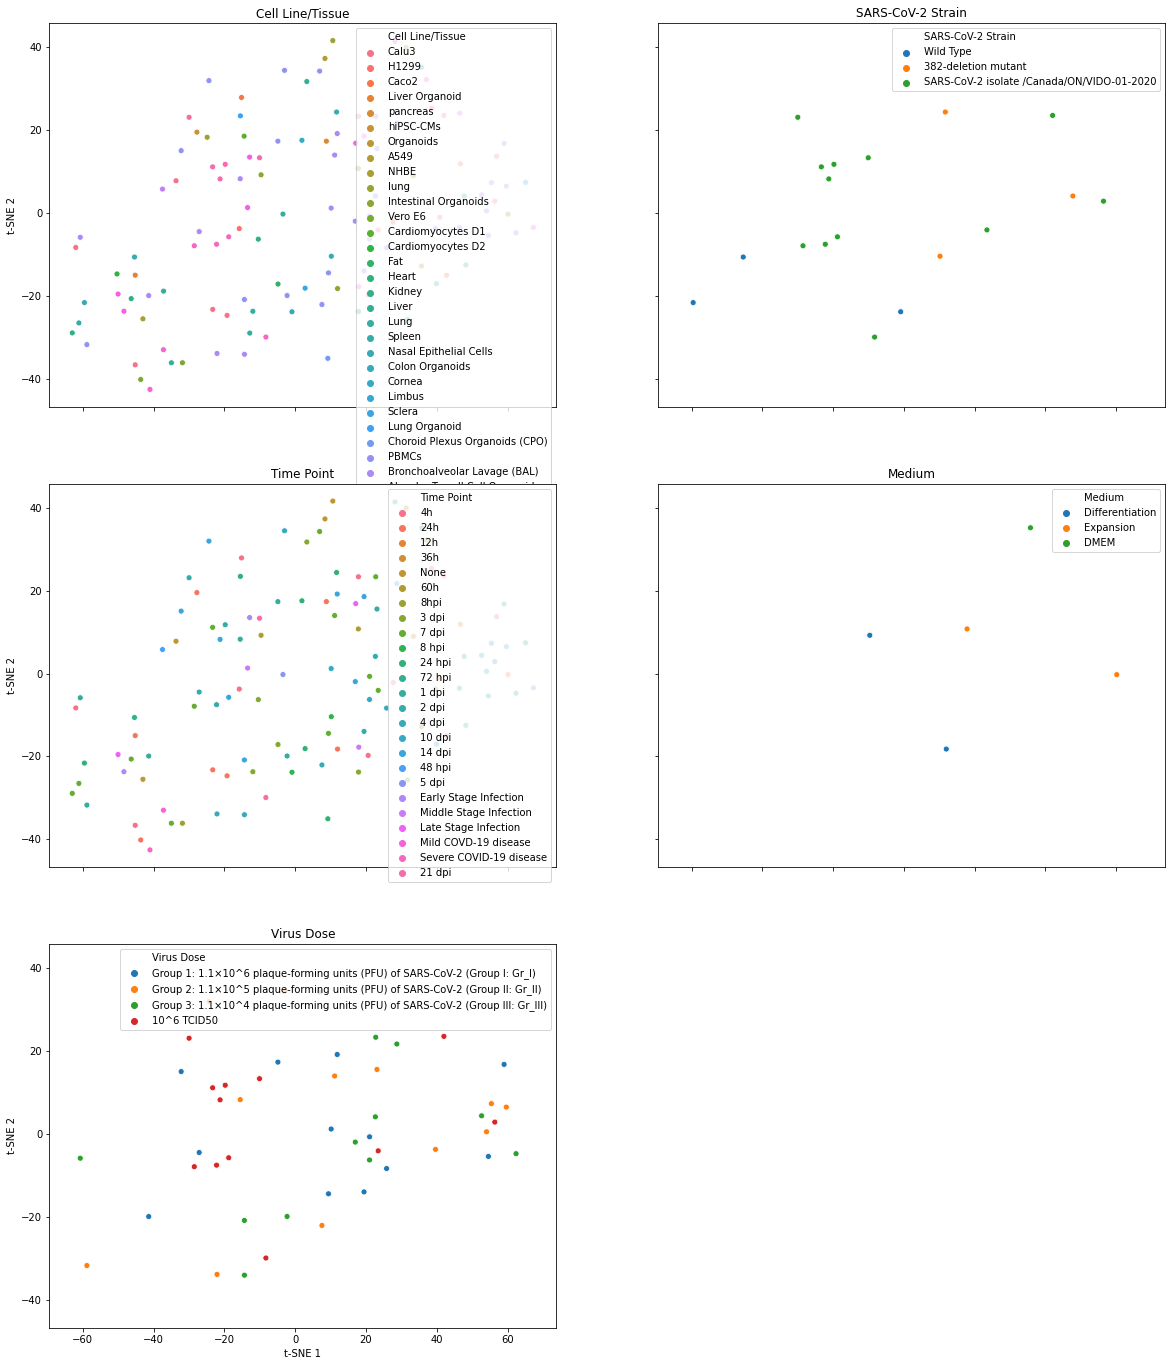

**Figure 14** t-SNE plot of LINCS L1000 CRISPR Perturbations (2021) reversers colored by metadata

**Figure 15** UMAP plot of LINCS L1000 CRISPR Perturbations (2021) reversers colored by Cell Line/Tissue

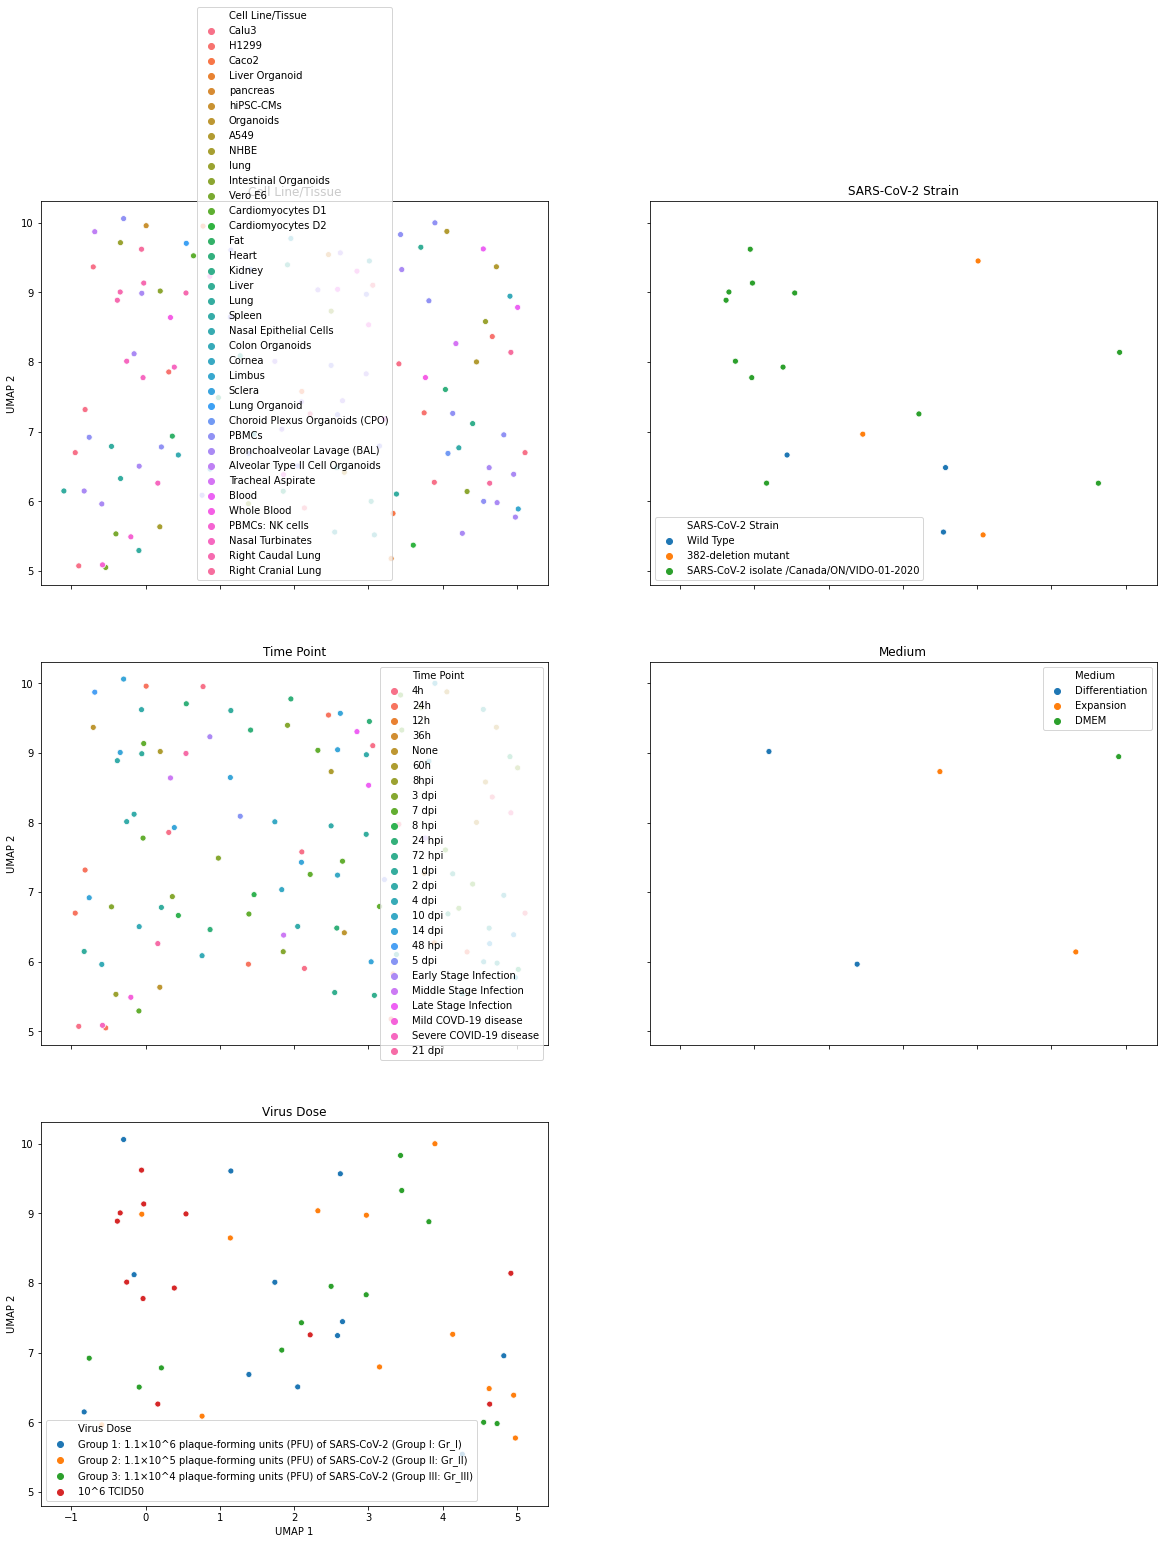

**Figure 16** UMAP plot of LINCS L1000 CRISPR Perturbations (2021) reversers colored by metadata

https://maayanlab.cloud/clustergrammer/viz/61087d81fe6520018063569a/clustergrammer_l1000_xpr_reversers.tsv


**Figure 17** Clustergrammer of consensus reverser perturbation of LINCS L1000 CRISPR Perturbations (2021) (quantile normalized scores) [Go to url](https://maayanlab.cloud/clustergrammer/viz/61087d81fe6520018063569a/clustergrammer_l1000_xpr_reversers.tsv)

<Figure size 1080x1080 with 0 Axes>

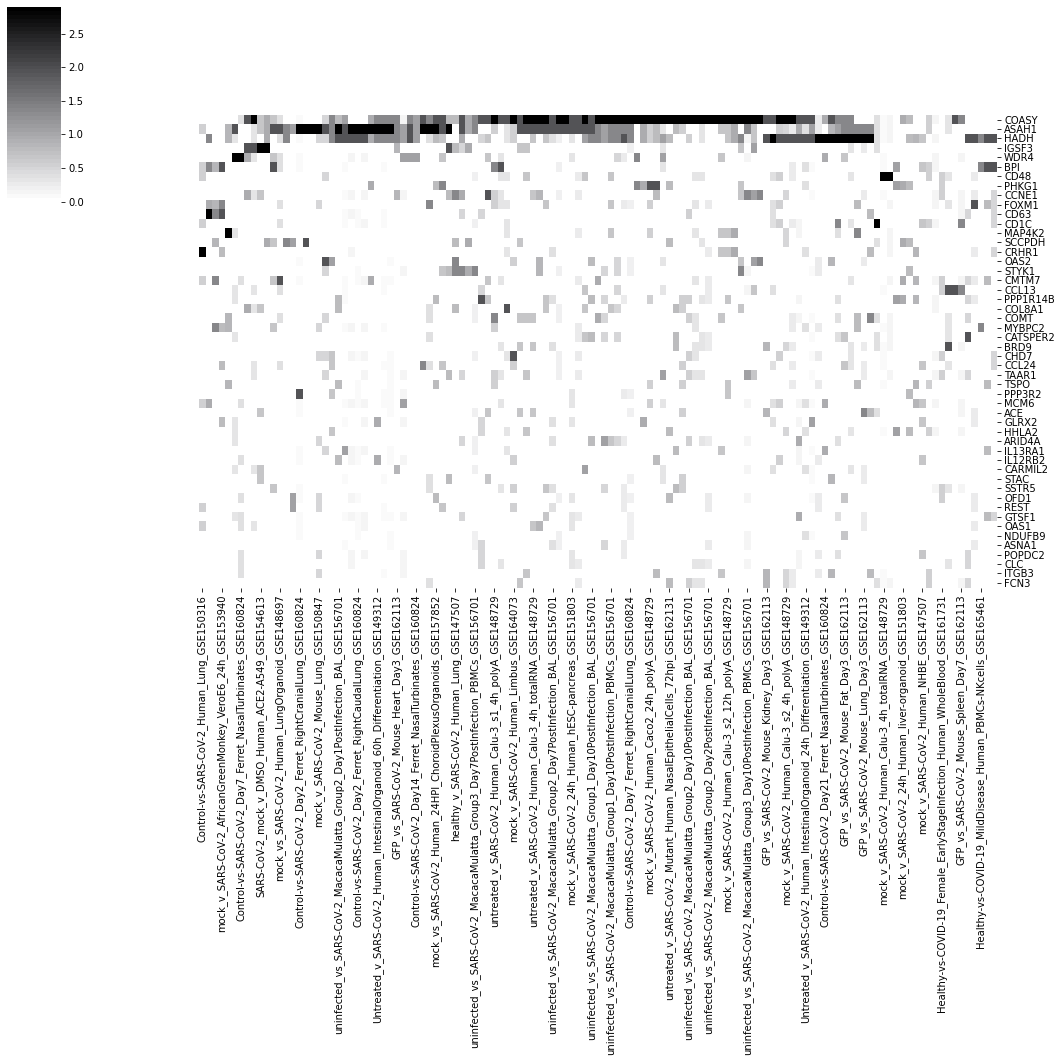

**Figure 18** Heatmap of consensus reverser perturbation of LINCS L1000 CRISPR Perturbations (2021) (quantile normalized scores)

### LINCS L1000 Chemical Perturbations (2021)

count    z-score       p-value
voriconazole        14  10.041733  0.000000e+00
BRD-K55082668       13   9.323658  0.000000e+00
BRD-K75649446       13   9.323658  0.000000e+00
entinostat         679   9.130065  0.000000e+00
CHEMBL-1222381     119   8.545134  0.000000e+00
BRD-K96475865       15   7.600815  1.476597e-14
BRD-K58044926       15   7.600815  1.476597e-14
geldanamycin       455   7.388668  7.416290e-14
mocetinostat       103   7.129569  5.033751e-13
BRD-K41762421       14   7.093026  6.560308e-13
iodophenpropit      16   6.614534  1.863620e-11
BRD-K47131467       13   6.585238  2.270784e-11
tanespimycin       468   6.481443  4.542478e-11
RG-4733             18   6.441273  5.923773e-11
danegaptide         21   6.130446  4.381658e-10
BRD-K26304855       25   5.959241  1.267058e-09
lucitanib           20   5.837199  2.654288e-09
GSK-J1              18   5.756555  4.292402e-09
FK-888              16   5.723060  5.231129e-09
vorinostat         485   5.675577  6.911097e-09
AGK-2               64   5.512161  1.772276e-08
trifluoperazine    253   5.476159  2.173284e-08
BRD-K16048293       13   5.370631  3.923074e-08
vortioxetine        18   5.250705  7.575922e-08
BRD-K13665559      160   5.247661  7.702137e-08

**Table 12** Top 25 reverser perturbagens using LINCS L1000 Chemical Perturbations (2021) dataset ([download](./pert_stat_l1000_cp_reversers.tsv))

untreated_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA_GSE148729  \
voriconazole                                                    0           
BRD-K55082668                                                   0           
BRD-K75649446                                                   0           
entinostat                                                      0           
CHEMBL-1222381                                                  0           

                mock_v_SARS-CoV-2_Human_Calu-3_s1_4h_polyA_GSE148729  \
voriconazole                                                    0      
BRD-K55082668                                                   1      
BRD-K75649446                                                   1      
entinostat                                                      0      
CHEMBL-1222381                                                  0      

                mock_v_SARS-CoV-2_Human_Calu-3_s1_24h_polyA_GSE148729  \
voriconazole                                                    0       
BRD-K55082668                                                   0       
BRD-K75649446                                                   0       
entinostat                                                      7       
CHEMBL-1222381                                                  3       

                mock_v_SARS-CoV-2_Human_Calu-3_s2_4h_polyA_GSE148729  \
voriconazole                                                    0      
BRD-K55082668                                                   1      
BRD-K75649446                                                   0      
entinostat                                                      0      
CHEMBL-1222381                                                  0      

                mock_v_SARS-CoV-2_Human_Calu-3_s2_12h_polyA_GSE148729  \
voriconazole                                                    0       
BRD-K55082668                                                   1       
BRD-K75649446                                                   0       
entinostat                                                     22       
CHEMBL-1222381                                                  4       

                untreated_v_SARS-CoV-2_Human_H1299_4h_polyA_GSE148729  \
voriconazole                                                    0       
BRD-K55082668                                                   0       
BRD-K75649446                                                   0       
entinostat                                                      0       
CHEMBL-1222381                                                  0       

                mock_v_SARS-CoV-2_Human_H1299_4h_polyA_GSE148729  \
voriconazole                                                   0   
BRD-K55082668                                                  0   
BRD-K75649446                                                  0   
entinostat                                                     0   
CHEMBL-1222381                                                 0   

                mock_v_SARS-CoV-2_Human_H1299_36h_polyA_GSE148729  \
voriconazole                                                    0   
BRD-K55082668                                                   0   
BRD-K75649446                                                   0   
entinostat                                                      3   
CHEMBL-1222381                                                  0   

                untreated_v_SARS-CoV-2_Human_Caco2_4h_polyA_GSE148729  \
voriconazole                                                    0       
BRD-K55082668                                                   0       
BRD-K75649446                                                   0       
entinostat                                                      1       
CHEMBL-1222381                                                  1       

                mock_v_SARS-CoV-2_Human_Caco2_4h_polyA_GSE148729  ...  \
voriconazole                      

**Table 13** Consensus reverser perturbation matrix for LINCS L1000 Chemical Perturbations (2021) ([download](./consensus_matrix_l1000_cp_reversers.tsv))

**Figure 19** t-SNE plot of LINCS L1000 Chemical Perturbations (2021) reversers colored by Cell Line/Tissue

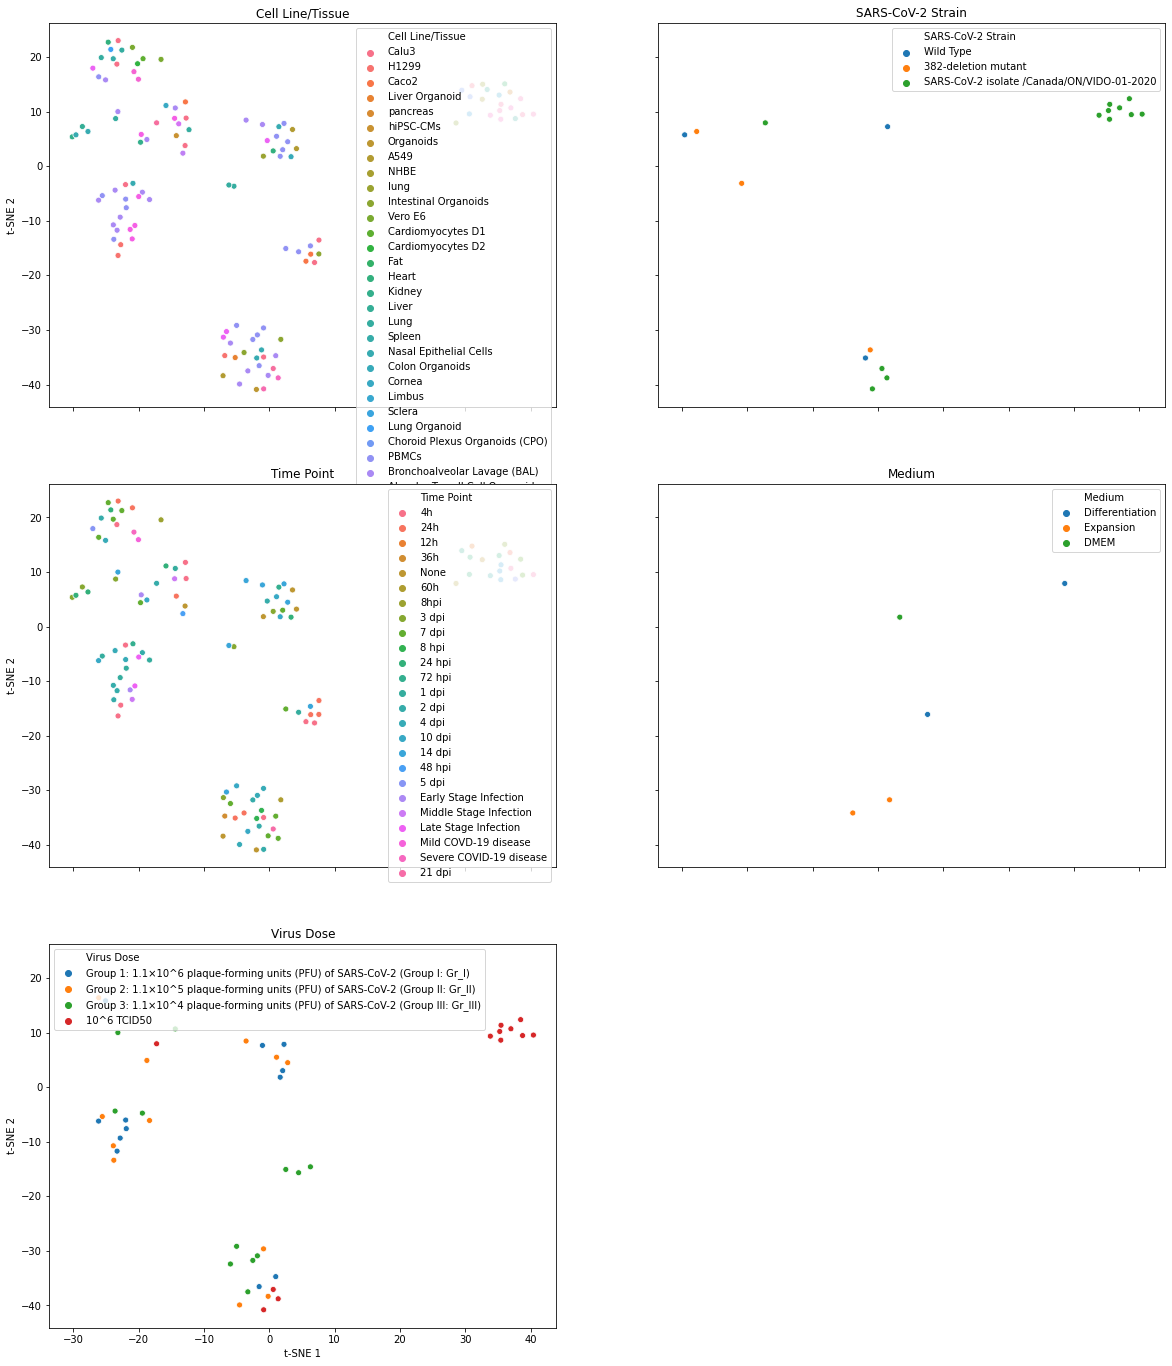

**Figure 20** t-SNE plot of LINCS L1000 Chemical Perturbations (2021) reversers colored by metadata

**Figure 21** UMAP plot of LINCS L1000 Chemical Perturbations (2021) reversers colored by Cell Line/Tissue

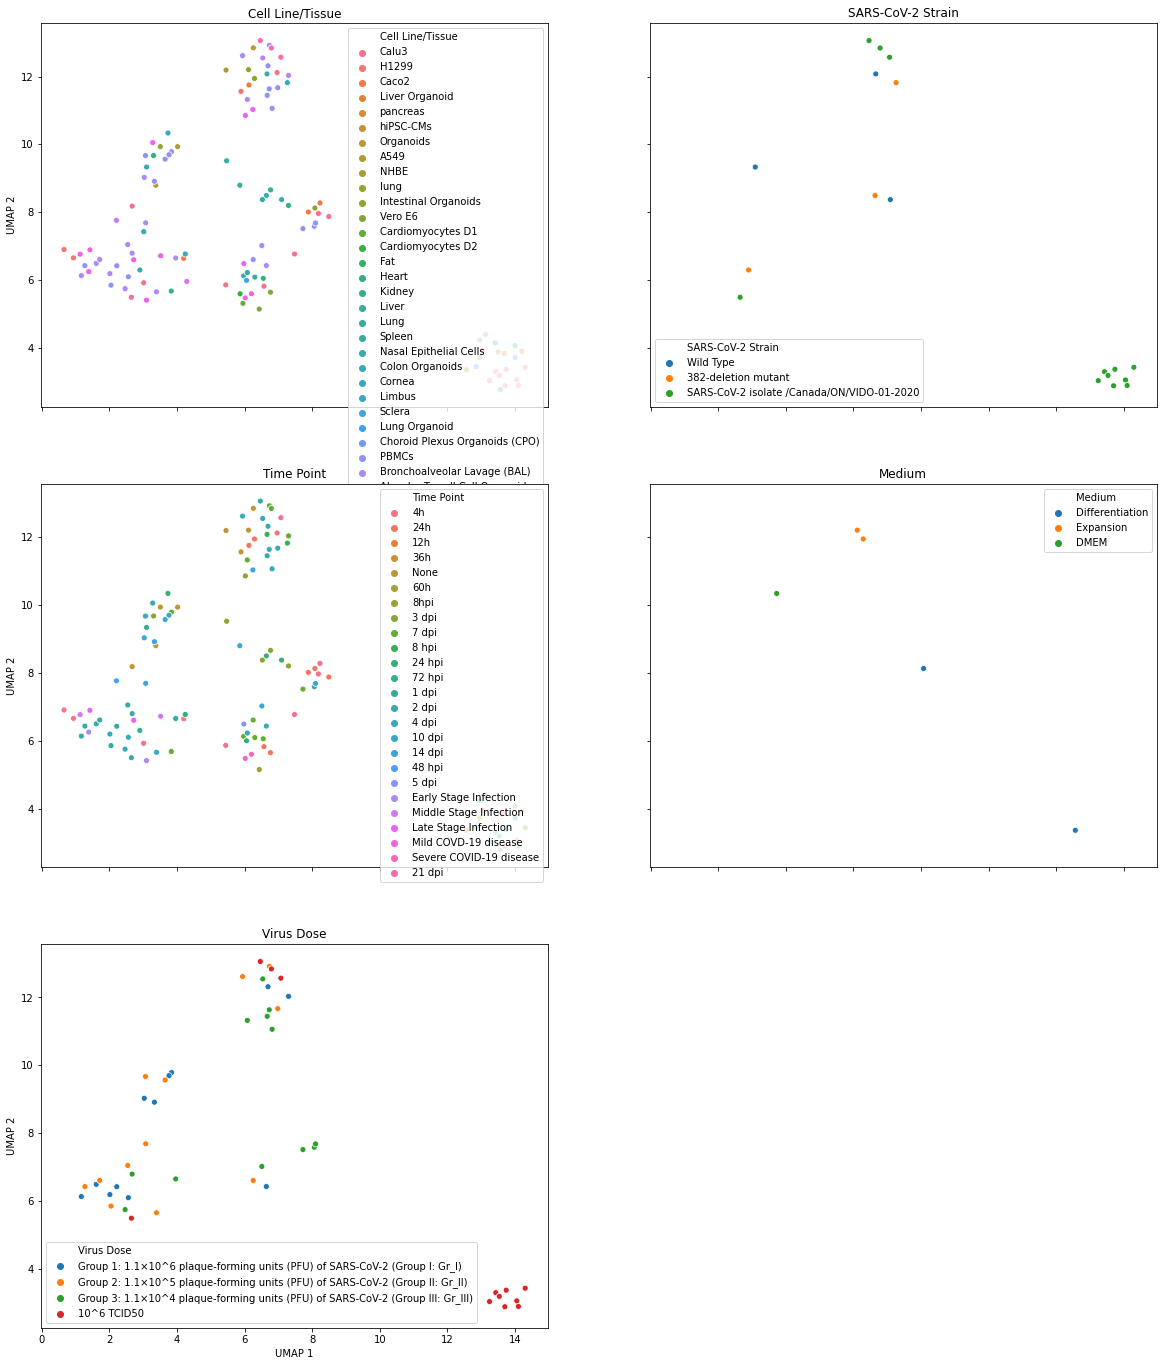

**Figure 22** UMAP plot of LINCS L1000 Chemical Perturbations (2021) reversers colored by metadata

https://maayanlab.cloud/clustergrammer/viz/61087d8e97f268000e93c7d7/clustergrammer_l1000_cp_reversers.tsv


**Figure 23** Clustergrammer of consensus reverser perturbation of LINCS L1000 Chemical Perturbations (2021) (quantile normalized scores) [Go to url](https://maayanlab.cloud/clustergrammer/viz/61087d8e97f268000e93c7d7/clustergrammer_l1000_cp_reversers.tsv)

<Figure size 1080x1080 with 0 Axes>

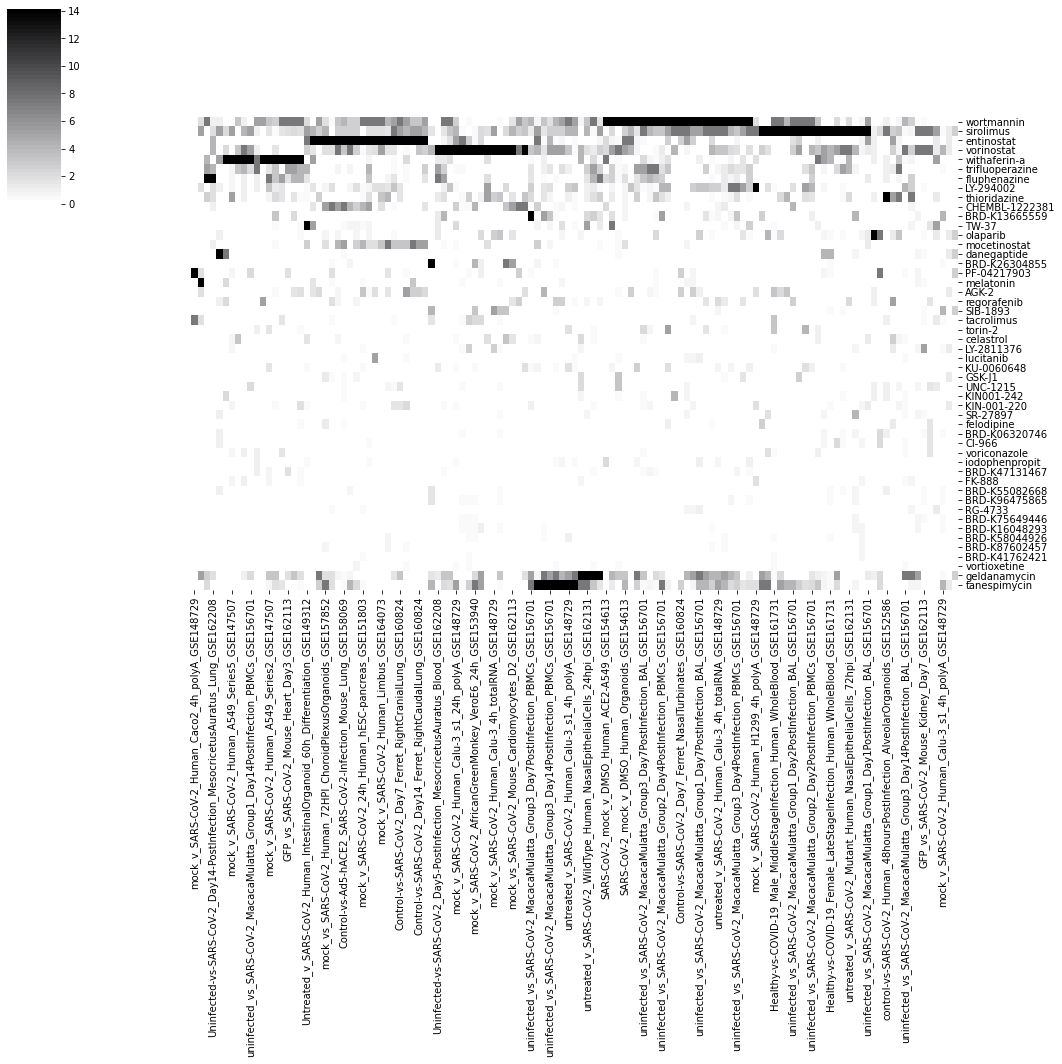

**Figure 24** Heatmap of consensus reverser perturbation of LINCS L1000 Chemical Perturbations (2021) (quantile normalized scores)

In [20]:
direction = "reversers"
for lib in datasets:
    library = dataset_map[lib]
    display(Markdown("### %s"%lib))
    index = set()
    pert_dict = enriched[direction][lib]
    for v in pert_dict.values():
        index = index.union(v.keys())
    df = pd.DataFrame(0, index=index, columns=pert_dict.keys())
    for k,v in pert_dict.items():
        for pert, cnt in v.items():
            df.at[pert, k] += cnt
    df = df.loc[df.sum(1).sort_values(ascending=False).index]
    filename = "pert_matrix_%s_%s.tsv"%(library.replace(" ","_"), direction)
    df.to_csv(filename, sep="\t")
#     display(df.head())
#     display(Markdown("**Table %d** Reverser perturbagens using %s dataset ([download](./%s))"%
#                      (table, lib, filename)))
    table += 1
    # stat_df = pd.DataFrame(0, index=df.index, columns=["count", "z-score", "p-value"])
    empirical_stat = pd.read_csv(S3_PREFIX + "%s_%s.tsv" % (library, direction), sep="\t", index_col=0)
    df = df[(df>0).sum(1) > len(df.columns) * perc]
    index = set(df.index).intersection(empirical_stat.index)
    filtered_df = df.loc[index]    
    if lib in gene_page:
        stat_df = pd.DataFrame(0, index=index, columns=["count", "z-score", "p-value", "Enrichr gene page"])
        stat_df['count'] = filtered_df.sum(1)
        # Compute zstat and p value
        stat_df["z-score"] = (filtered_df.mean(1) - empirical_stat["mean"]) / empirical_stat["std"]
        stat_df["p-value"] = stat_df['z-score'].apply(lambda x: 1-st.norm.cdf(x))

        #Filter by p-value
        stat_df = stat_df[stat_df["p-value"]<alpha].sort_values(by=["z-score"], ascending=False)

        stat_df['Enrichr gene page'] = ["https://maayanlab.cloud/Enrichr/#find!gene=%s"%i for i in stat_df.index]
        filename = "pert_stat_%s_%s.tsv"%(lib.replace(" ","_"), direction)
        stat_df.to_csv(filename, sep="\t")
        stat_df['Enrichr gene page'] = stat_df['Enrichr gene page'].apply(make_clickable)
        stat_html = stat_df.head(25).to_html(escape=False)
        display(HTML(stat_html))
    else:
        stat_df = pd.DataFrame(0, index=index, columns=["count", "z-score", "p-value"])
        stat_df['count'] = filtered_df.sum(1)
        # Compute zstat and p value
        stat_df["z-score"] = (filtered_df.mean(1) - empirical_stat["mean"]) / empirical_stat["std"]
        stat_df["p-value"] = stat_df['z-score'].apply(lambda x: 1-st.norm.cdf(x))

        #Filter by p-value
        stat_df = stat_df[stat_df["p-value"]<alpha].sort_values(by=["z-score"], ascending=False)

        filename = "pert_stat_%s_%s.tsv"%(library.replace(" ","_"), direction)
        stat_df.to_csv(filename, sep="\t")
        display(stat_df.head(25))
    display(Markdown("**Table %d** Top 25 reverser perturbagens using %s dataset ([download](./%s))"%
                     (table, lib, filename)))

    table+=1

    consensus = df.loc[stat_df.index[0:top_perts]]
    consensus_norm = quantile_normalize(consensus)
#     consensus_norm = consensus.subtract(empirical_stat.loc[consensus.index, "mean"], axis=0).divide(empirical_stat.loc[consensus.index, "std"], axis=0)
    if len(consensus.index) > top_perts:
        consensus = consensus.loc[consensus.index[:top_perts]]
    filename = "consensus_matrix_%s_%s.tsv"%(library.replace(" ","_"), direction)
    consensus.to_csv(filename, sep="\t")
    display(consensus.head())
    display(Markdown("**Table %d** Consensus reverser perturbation matrix for %s ([download](./%s))"%
                     (table, lib, filename)))

    table+=1
    
    plot_label = "%s %s"%(lib, direction)
    figure = get_tsne(consensus_norm, plot_label, figure)
    figure = get_umap(consensus_norm, plot_label, figure)
    

    label = "Clustergrammer of consensus reverser perturbation of %s (quantile normalized scores)"%lib
    name = "clustergrammer_%s_%s.tsv"%(library.replace(" ", "_"), direction)
    figure = clustergrammer(consensus_norm.loc[consensus.index], name, figure, label)

    label = "Heatmap of consensus reverser perturbation of %s (quantile normalized scores)"%lib
    name = "heatmap_%s_%s.png"%(library.replace(" ", "_"), direction)
    figure = heatmap(consensus_norm.loc[consensus.index], name, figure, label)
